In [134]:
import torch as T
import torch.nn as nn

import torchvision as tv
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

T.__version__

'1.6.0'

In [135]:
DEVICE = 'cuda'

In [136]:
def get_dataloader(bs, msg_size):
    ds = tv.datasets.MNIST(
        '../.data',
        train=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,), inplace=True)
        ]),
        download=True
    )

    class Dataset(T.utils.data.Dataset):
        def __len__(self):
            return len(ds)

        def __getitem__(self, idx):
            X, _y = ds[idx]
            return {'img': X.to(DEVICE), 'msg': T.randn(msg_size).to(DEVICE)}

    return T.utils.data.DataLoader(
        dataset=Dataset(),
        batch_size=bs,
        shuffle=True,
    )

In [137]:
dl = get_dataloader(bs=64, msg_size=32)
it = iter(dl)
batch = next(it)
batch['img'].shape, batch['msg'].shape, batch['img'].min(), batch['msg'].min(), batch['msg'].max()

(torch.Size([64, 1, 28, 28]),
 torch.Size([64, 32]),
 tensor(0., device='cuda:0'),
 tensor(-3.5222, device='cuda:0'),
 tensor(3.4289, device='cuda:0'))

In [139]:
def dense(i, o, a=nn.LeakyReLU(0.2)):
    l = nn.Linear(i, o)
    if a is None: return l
    return nn.Sequential(l, a)

def sequence(sizes, ctor):
    layers = [ctor(i, o) for i, o in zip(sizes, sizes[1:])]
    return nn.Sequential(*layers) 

In [146]:
msg_size = 64
ae_latent_size = 16
expand_size = 784

class AE(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = nn.Sequential(
            sequence([expand_size, 128, 64], dense),
            dense(64, ae_latent_size, a=None),
        )
            
        self.dec = nn.Sequential(
            sequence([ae_latent_size, 64, 128], dense),
            dense(128, expand_size, a=nn.Sigmoid()),
        )

    def _forward(self, x):
        old_shape = x.shape
        x = x.view(old_shape[0], -1)
        latent = self.enc(x)
        x = self.dec(latent)
        x = x.view(*old_shape)
        return x, latent
        
    def forward(self, x):
        reconstruction, latenr = self._forward(x)
        return reconstruction

class Hourglass(nn.Module):
    def __init__(self):
        super().__init__()
        self.gen = nn.Sequential(
            sequence([msg_size, 64, 128], dense),
            dense(128, expand_size, a=nn.Sigmoid()),
        )
        
        self.dis = nn.Sequential(
            sequence([expand_size, 128, 64], dense),
            dense(64, msg_size, a=None),
        )
        
        self.ae = AE()
        self.criterion = nn.MSELoss()
        self.initial_msgs = T.randn(64, msg_size).to(DEVICE)

    def configure_optim(self, lr):
        self.optim_ae = T.optim.Adam(self.ae.parameters(), lr=lr)
#         self.optim_gen = T.optim.Adam([
#             *self.gen.parameters(),
#             *self.dis.parameters(),
#         ], lr=lr)
        self.optim_gen = T.optim.Adam(self.parameters(), lr=lr)

    def generate_initial_msgs(self):
        imgs = self.gen(self.initial_msgs)
        return imgs.view(self.initial_msgs.shape[0], 1, 28, 28)

    def optim_step(self, batch):
        msg = batch['msg']
        img = batch['img']

#         img = img + T.randn_like(img).to(DEVICE) / 2

        pred_img = self.ae(img)
        gen_img = self.gen(msg)
        ae_gen_img, latent_code = self.ae._forward(gen_img)
        pred_msg = self.dis(ae_gen_img)
        
#         gen_img = gen_img + T.randn_like(gen_img).to(DEVICE) / 2

        ae_loss = self.criterion(pred_img, img)
        gen_loss = self.criterion(pred_msg, msg)
        loss = ae_loss + gen_loss

        if loss.requires_grad:
            self.optim_ae.zero_grad()
            self.optim_gen.zero_grad()

            loss.backward()
            self.optim_ae.step()
            self.optim_gen.step()

        return {
            'loss': loss.item(),
            'ae_loss': ae_loss.item(),
            'gen_loss': gen_loss.item(),
            'gen_img': gen_img,
        }

    def forward(self, msg):
        gen_img = self.gen(msg)
        ae_gen_img = self.ae(gen_img)
        pred_msg = self.dis(ae_gen_img)
        return pred_msg

In [147]:
model = Hourglass().to(DEVICE)
model.configure_optim(lr=0.0001)

In [148]:
def show_example(model):
    reconstr_img = model.ae(batch['img'])
    
    imgs = model.generate_initial_msgs()
    imgs = T.cat([imgs, reconstr_img])

    example = tv.utils.make_grid(imgs, nrow=16, padding=2).permute(1, 2, 0)
    example = example.detach().cpu().numpy()

    fig = plt.figure(figsize=(10,  5))
    ax = fig.add_subplot()
    ax.imshow(example)
    plt.show()

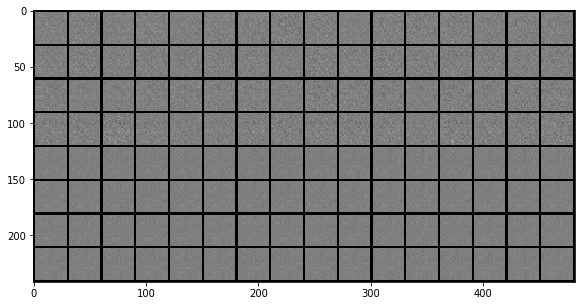

In [149]:
show_example(model)

In [150]:
from tqdm.auto import tqdm

def fit(model, dataloader, epochs):
    for e in tqdm(range(epochs)):
        tr = tqdm(dataloader)
        for i, batch in enumerate(tr):
            info = model.optim_step(batch)
            loss = info['loss']
            gen_loss = info['gen_loss']
            ae_loss = info['ae_loss']
            tr.set_description(f'loss={loss:.5f}, gen_loss={gen_loss:.5f}, ae_loss={ae_loss:.5f}')

            if i % 200 == 0:
                show_example(model)

In [152]:
fit(
    model=model,
    dataloader=get_dataloader(bs=128, msg_size=msg_size),
    epochs=100,
)